In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.stats as jss
from ppe.dirichlet import dirichlet_log_likelihood, alpha_mle_


In [65]:
def replace_value_index(lst, index, new_value):
    assert lst[index] == new_value
    lst[index] = new_value
    return lst


def set_derivative_fn_discrete(
    rng_key,
    num_samples,
    sampler_fn,
    pmf_fn,
    pivot_fns,
    total_model_probs,
    total_expert_probs,
    covariate
):

    @jax.jit
    def nonstochastic_derivative(alpha, probs, expert_probs, index):
        # Compute the gradient of the dirichlet likelihood wrt the probabilities

        if alpha is None:
            # If alpha is not provided, compute the MLE
            def likelihood_fn(probs):
                # Make the computation of alpha depend on the current probs
                total_model_probs = replace_value_index(total_model_probs, index, probs)
                alpha = alpha_mle_(total_model_probs, total_expert_probs)
                return dirichlet_log_likelihood(alpha, probs, expert_probs)

        else:
            likelihood_fn = lambda probs: dirichlet_log_likelihood(
                alpha, probs, expert_probs
            )

        grad_fn = jax.grad(likelihood_fn)
        likelihood_gradient = grad_fn(probs)
        return likelihood_gradient

    @jax.jit
    def stochastic_derivative(lambd, partition, covariate):
        # Compute stochastic gradient of each prior predictive probability wrt the hyperparameters
        #a = partition
        
        pivot_sample_1 = sampler_fn(jr.key(0), (num_samples,))
        pivot_sample_2 = sampler_fn(jr.key(1), (num_samples,))
        pivot_sample_3 = sampler_fn(jr.key(2), (num_samples,))

        def function_to_optimize(lambd, partition):
            theta_1 = pivot_fns[0](lambd, pivot_sample_1)
            theta_2 = pivot_fns[1](lambd, pivot_sample_2)
            theta_3 = pivot_fns[2](lambd, pivot_sample_3)
                    
            theta = jnp.array([theta_1, theta_2, theta_3]).T
            
            prob_1 = (jss.norm.cdf(theta@covariate)).mean()
                                    
            val = jnp.array([prob_1, 1-prob_1]) ### bernoulli pmf for class 1 and class 0 respectively
                        
            return val

        stochastic_gradient_fn = jax.jacobian(function_to_optimize, argnums=0)  ## 1st row: dval[0]/dλ, 2nd row dval[1]/dλ
        
        stochastic_gradient_fn_val = stochastic_gradient_fn(lambd, partition)
        
        return stochastic_gradient_fn_val
        
    return nonstochastic_derivative, stochastic_derivative


In [66]:

import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.stats as jss
from ppe.dirichlet import dirichlet_log_likelihood


def get_bernoulli_probs(partition, lam, covariate_set):

    nom = jnp.inner(jnp.array(lam[:3]), covariate_set)
    den = jnp.sqrt(1 + covariate_set.T@jnp.diag(jnp.array(lam[3:]))@covariate_set)

    p1 = jss.norm.cdf(nom / den)
    
    return jnp.array([p1, 1 - p1])  ### bernoulli pmf for class 1 and class 0 respectively



# TODO: Add test for alpha_mle
if __name__ == "__main__":
    partitions = jnp.array([0., 1.])
    expert_probs = jnp.array([0.3, 0.7])

    # Try simple Gaussian example
    alpha = 1.0
    lambd_0 = jnp.array([1, 0.5, 0.2, 2.1, 1., 0.7])
    covariate = jnp.array([1., 0.4, 2.])
    rng_key = jr.key(0)
    num_samples = 1_000_000
    sampler_fn = jr.normal
    pmf_fn = lambda theta, a, covariate: jss.bernoulli.pmf(a, p = jss.norm.cdf(theta@covariate)) ## not used here
    pivot_fn_1 = lambda lambd, z: lambd[0] + lambd[3] * z
    pivot_fn_2 = lambda lambd, z: lambd[1] + lambd[4] * z
    pivot_fn_3 = lambda lambd, z: lambd[2] + lambd[5] * z
    pivot_fns = [pivot_fn_1,pivot_fn_2,pivot_fn_3]
    # In this case we can obtain probs in closed form, but in general we would need stochastic estimates
    probs = get_bernoulli_probs(partitions, lambd_0, covariate)
    total_model_probs = [probs]
    total_expert_probs = [expert_probs]
    nonstochastic_derivative, stochastic_derivative = set_derivative_fn_discrete(
        rng_key,
        num_samples,
        sampler_fn,
        pmf_fn,
        pivot_fns,
        total_model_probs,
        total_expert_probs,
        covariate
    )
    derivative_1 = nonstochastic_derivative(alpha, probs, expert_probs, index=0)
    #vmap_stochastic_derivative = jax.vmap(stochastic_derivative, in_axes=(None, 0))
    derivative_2 = stochastic_derivative(lambd_0, partitions, covariate)
    
    print(derivative_2)

    derivative = jnp.dot(derivative_2.T, derivative_1)

    def test_fn(lambd):
        probs = get_bernoulli_probs(partitions, lambd, covariate)
        return dirichlet_log_likelihood(alpha, probs, expert_probs)

    test_value = jax.grad(test_fn)(lambd_0)
    print("stochastic gradient", derivative)
    print("Non stochastic gradient", test_value)
    assert jnp.allclose(test_value, derivative, atol=1e-1)
    print("Test passed")


[[ 0.12232186  0.04892875  0.24464372 -0.05452796 -0.00414541 -0.07282704]
 [-0.12232186 -0.04892875 -0.24464372  0.05452796  0.00414541  0.07282704]]
stochastic gradient [-0.46940294 -0.1877612  -0.9388059   0.20924784  0.01590778  0.2794695 ]
Non stochastic gradient [-0.50348127 -0.20139252 -1.0069625   0.06646618  0.01063459  0.26586473]


AssertionError: 

In [63]:
jnp.array([-0.13120234, -0.05248094, -0.26240468,  0.01732044,  0.00277127, 0.06928178])/jnp.array([-0.12232186, -0.04892875, -0.24464372,  0.05452796,  0.00414541,  0.07282704])

## the nominator has the true gradient. The are off by a constant mupltiplicatively


Array([1.0725993 , 1.0725993 , 1.0725993 , 0.31764325, 0.6685153 ,
       0.95131946], dtype=float32)

In [115]:
from ppe.dirichlet import Dirichlet




def gradient_descent(
        total_expert_probs,
        lam_0,
        iters,
        step_size,
        tol,
        covariates,
        get_lik_and_grad_progression=True,
    ):

        lam_old = lam_0  ## initial value for the hyperparameters

        lik_progression = []
        grad_progression = []

        for i in range(iters):
            
            prev_model_probs = [get_bernoulli_probs(partitions, lam_old, covariate) for covariate in covariates]
            
            dir_class = Dirichlet(alpha=22.0, J=3)
            
            prev_lik = dir_class.sum_llik(prev_model_probs, total_expert_probs)

            lik_progression.append(prev_lik)
            
            
            rng_key = jr.key(0)
            num_samples = 1_000_000
            sampler_fn = jr.normal
            pmf_fn = lambda theta, a, covariate: jss.bernoulli.pmf(a, p = jss.norm.cdf(theta@covariate)) ## not used here
            pivot_fn_1 = lambda lambd, z: lambd[0] + lambd[3] * z
            pivot_fn_2 = lambda lambd, z: lambd[1] + lambd[4] * z
            pivot_fn_3 = lambda lambd, z: lambd[2] + lambd[5] * z
            pivot_fns = [pivot_fn_1,pivot_fn_2,pivot_fn_3]
            # In this case we can obtain probs in closed form, but in general we would need stochastic estimates
            probs = get_bernoulli_probs(partitions, lam_old, covariate)
            total_model_probs = [probs]
            #total_expert_probs = [expert_probs]
            nonstochastic_derivative, stochastic_derivative = set_derivative_fn_discrete(
                rng_key,
                num_samples,
                sampler_fn,
                pmf_fn,
                pivot_fns,
                total_model_probs,
                total_expert_probs,
                covariate
            )
            
            
            
            derivative_1 = nonstochastic_derivative(alpha, probs, expert_probs, index=0)
            #vmap_stochastic_derivative = jax.vmap(stochastic_derivative, in_axes=(None, 0))
            derivative_2 = stochastic_derivative(lambd_0, partitions, covariate)

            grad_dir_lam = - jnp.dot(derivative_2.T, derivative_1)

            grad_progression.append(jnp.linalg.norm(grad_dir_lam))

            lam_new = lam_old - step_size * grad_dir_lam

            curr_model_probs = [get_bernoulli_probs(partitions, lam_new, covariate) for covariate in covariates]

            curr_lik = dir_class.sum_llik(curr_model_probs, total_expert_probs)

            if (abs(curr_lik - prev_lik) < tol):  ## Stopping criterion: the dirichlet log likelihood changes less than "tol" between two iterations
                break

            lam_old = lam_new

        if get_lik_and_grad_progression:
            return lam_new, -jnp.array(lik_progression), jnp.array(grad_progression)

        return lam_new




In [116]:
lam_new, lik_progression, grad_progression = gradient_descent(
        total_expert_probs = [jnp.array([0.35, 0.65]), jnp.array([0.3, 0.7]), jnp.array([0.2, 0.8])],
        lam_0 = jnp.ones(6),
        iters = 200,
        step_size = 0.3,
        tol = 1e-5,
        covariates = [jnp.array([1.3, 0.7, 0.5]), jnp.array([1, 0.5, 0.4]), jnp.array([0.3, 0.7, 2])],
        get_lik_and_grad_progression=True,
    )




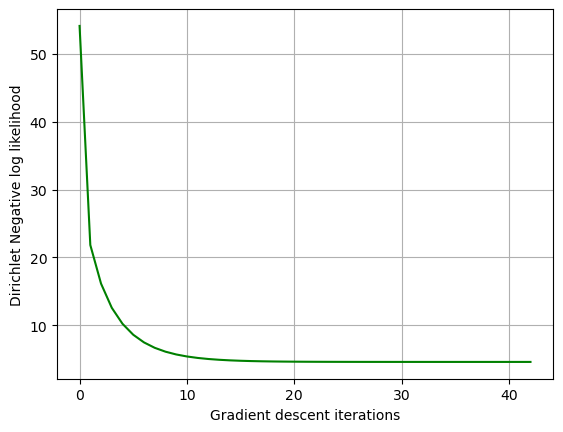

In [117]:
import matplotlib.pyplot as plt


plt.plot(lik_progression, color="Green", linewidth=1.5)
plt.xlabel("Gradient descent iterations")
plt.ylabel("Dirichlet Negative log likelihood")
plt.grid(True)
plt.show()

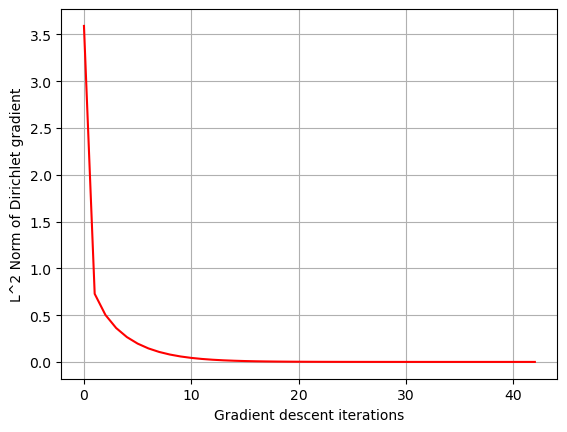

In [118]:
plt.plot(grad_progression, color="Red", linewidth=1.5)
plt.xlabel("Gradient descent iterations")
plt.ylabel("L^2 Norm of Dirichlet gradient")
plt.grid(True)
plt.show()

In [119]:
lam_new

Array([ 0.22240731,  0.6889627 , -0.55518556,  1.3466312 ,  1.0263519 ,
        1.4629571 ], dtype=float32)

In [120]:
dir_class = Dirichlet(alpha=2.0, J=3)
best_model_probs = [get_bernoulli_probs(partitions, lam_new, covariate) for covariate in [jnp.array([1.3, 0.7, 0.5]), jnp.array([1, 0.5, 0.4]), jnp.array([0.3, 0.7, 2])]]
total_expert_probs = [jnp.array([0.35, 0.65]), jnp.array([0.3, 0.7]), jnp.array([0.2, 0.8])]

dir_class.alpha_mle(best_model_probs, total_expert_probs)


Array(3.5907586, dtype=float32)

In [121]:
best_model_probs

[Array([0.5958285 , 0.40417153], dtype=float32),
 Array([0.5810996 , 0.41890037], dtype=float32),
 Array([0.41866308, 0.5813369 ], dtype=float32)]

In [93]:
total_expert_probs

[Array([0.35, 0.65], dtype=float32),
 Array([0.3, 0.7], dtype=float32),
 Array([0.2, 0.8], dtype=float32)]

In [135]:
import jax.numpy as jnp
from jax import grad,jacobian,vmap
import pandas as pd
import numpy as np
import jax.scipy.special as sps
import jax.scipy.stats as scs
from jax import random
import pymc as pm
from scipy.special import digamma
import matplotlib.pyplot as plt

In [39]:
class priors:
    
    def pivot(self, theta, *args, **kwds):
        
        """
        Pivot function of the distribution
        """
        
        return self.pivot(theta, *args, **kwds)
    
    def inverse_pivot(self, x, *args, **kwds):
        
        """
        Inverse pivot function of the distribution
        """
        
        return self.inverse_pivot(x, *args, **kwds)
    
    def sample_x(self, *args, **kwds):
        
        """
        Function to sample from X (independent from the hyperparameters lambda)
        """
        
        return self.sample_x(*args, **kwds)
    
    def grad_inverse_pivot(self, x, *args, **kwds):
        
        """
        Gradient of the inverse pivot with respect to the hyperparameters lambda
        """
        
        return self.grad_inverse_pivot(x, *args, **kwds)
    


class model_probabilities:
    
    def __init__(self, is_discrete=False):
        self.is_discrete = is_discrete
    
    def cdf(self, y, *args, **kwds):
        
        return self.cdf(y, *args, **kwds)
    
    def pdf(self, y, *args, **kwds):
        
        return self.pdf(y, *args, **kwds)
    
    def partition_prob(self, partition, *args, **kwds):
        
        if self.is_discrete:
            return self.pdf(partition, *args, **kwds)
        
        a = partition[0]
        b = partition[1]
        
        return self.cdf(b, *args, **kwds) - self.cdf(a, *args, **kwds)
        
    def grad_partition_prob(self, partition, *args, **kwds):
        
        return self.grad_partition_prob(partition, *args, **kwds)
    

class gaussian_prior(priors):
    
    def __init__(self, mu=None, sigma=None):
        super().__init__()
        self.mu = mu
        self.sigma = sigma
        self.is_discrete = False
    
    def _update(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def pivot(self, theta):
        
        return (theta - self.mu)/self.sigma
    
    def inverse_pivot(self, x):
        
        return x * self.sigma + self.mu
    
    def grad_inverse_pivot(self, x):
        
        dsigma = x
        dmu = jnp.ones(len(dsigma)) if len(dsigma) > 1 else 1.
        
        return jnp.array([dmu, dsigma]) ## 1st row is dmu, 2nd row is dsigma
    
    def sample_x(self, size):
        
        return np.random.normal(size=size)
    
        



class gaussian_model_probs(model_probabilities):
    
    def __init__(self, mu=None, sigma=None):
        super().__init__()
        self.mu = mu
        self.sigma = sigma
        self.is_discrete = False
    
    def _update(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        
    def cdf(self, x):
        
        x = np.asarray(x)
        return scs.norm.cdf(x, loc = self.mu, scale = self.sigma)
    
    def model_prob_gradient(self, partition):
        
        a = partition[0]
        b = partition[1]
        
        #x = jnp.asarray(x)
        
        #dmu = - (1/self.sigma) * scs.norm.pdf(b, loc=self.mu, scale=self.sigma) + (1/self.sigma) * scs.norm.pdf(a, loc=self.mu, scale=self.sigma)
        dmu = - scs.norm.pdf(b, loc=self.mu, scale=self.sigma) + scs.norm.pdf(a, loc=self.mu, scale=self.sigma)
        #dsigma = -((b - self.mu) / self.sigma**2) * scs.norm.pdf(b, loc=self.mu, scale=self.sigma) + ((a - self.mu) / self.sigma**2) * scs.norm.pdf(a, loc=self.mu, scale=self.sigma)
        dsigma = -((b - self.mu) / self.sigma) * scs.norm.pdf(b, loc=self.mu, scale=self.sigma) + ((a - self.mu) / self.sigma) * scs.norm.pdf(a, loc=self.mu, scale=self.sigma)
        
        return jnp.array([dmu, dsigma]) ## 1st row is dmu, 2nd row is dsigma
        
        #return grad(self.jax_helper_cdf, argnums=1)(b, [self.mu, self.sigma]) - grad(self.jax_helper_cdf, argnums=1)(a, [self.mu, self.sigma]) ### IMPROVE THIS WITH VMAP!!!
    
    #def jax_helper_cdf(self, x, params):
        
        #mu = params[0]
        #sigma = params[1]
        
        #return scs.norm.cdf(x, loc = mu, scale = sigma)
    
    



   

In [40]:


class bernoulli_model_probs(model_probabilities):
    
    def __init__(self, p=None):
        super().__init__()
        self.p = p
        self.is_discrete = True
    
    def _update(self, p):
        self.p = p
        
    def pmf(self, x):
        
        x = np.asarray(x)
        return scs.bernoulli.pmf(x, p=self.p)
    
    def model_prob_gradient(self, partition):
                
        dp = jnp.array([2*partition - 1]*len(self.p))
        
        return dp

In [41]:
def model_prob_input(theta, covariate):
    
    return scs.norm.cdf(theta @ covariate, loc=0, scale=1)
    #return scs.norm.cdf(theta, loc=0, scale=1)



In [44]:
## 3D

import scipy.stats as scs

mu_1 = 1.
sigma_1 = 2.1

mu_2 = 0.5
sigma_2 = 1.

mu_3 = 0.2
sigma_3 = 0.7


partition = 0.
covariate = jnp.array([1, 0.4, 2])
#covariate = jnp.array([1])



gs_prior_1 = gaussian_prior(mu = mu_1, sigma = sigma_1)
gs_prior_2 = gaussian_prior(mu = mu_2, sigma = sigma_2)
gs_prior_3 = gaussian_prior(mu = mu_3, sigma = sigma_3)

x_samples = gs_prior_1.sample_x(1000000)

theta_1 = gs_prior_1.inverse_pivot(x_samples)
theta_2 = gs_prior_2.inverse_pivot(x_samples)
theta_3 = gs_prior_3.inverse_pivot(x_samples)


theta = jnp.array([theta_1, theta_2, theta_3]).T

bern_input = model_prob_input(theta, covariate)
#bern_input = model_prob_input(theta_1, covariate)


bern_probs = bernoulli_model_probs(bern_input)

prob_y_given_theta_dtheta_samples = bern_probs.model_prob_gradient(partition) ### times the gradient for the CDF(x*theta)

pivot_gaussian_inverse_grad_samples_1 = gs_prior_1.grad_inverse_pivot(x_samples)
pivot_gaussian_inverse_grad_samples_2 = gs_prior_2.grad_inverse_pivot(x_samples)
pivot_gaussian_inverse_grad_samples_3 = gs_prior_3.grad_inverse_pivot(x_samples)



#ppe_dmu_1 = jnp.mean(prob_y_given_theta_dtheta_samples * covariate[0] * scs.norm.pdf(theta_1) * pivot_gaussian_inverse_grad_samples_1[0,:])
#ppe_dsigma_1 = jnp.mean(prob_y_given_theta_dtheta_samples * covariate[0] * scs.norm.pdf(theta_1) * pivot_gaussian_inverse_grad_samples_1[1,:])

ppe_dmu_1 = jnp.mean(prob_y_given_theta_dtheta_samples * covariate[0] * jss.norm.pdf(theta @ covariate) * pivot_gaussian_inverse_grad_samples_1[0,:])
ppe_dsigma_1 = jnp.mean(prob_y_given_theta_dtheta_samples * covariate[0] * jss.norm.pdf(theta @ covariate) * pivot_gaussian_inverse_grad_samples_1[1,:])
ppe_dmu_2 = jnp.mean(prob_y_given_theta_dtheta_samples * covariate[1] * jss.norm.pdf(theta @ covariate) * pivot_gaussian_inverse_grad_samples_2[0,:])
ppe_dsigma_2 = jnp.mean(prob_y_given_theta_dtheta_samples * covariate[1] * jss.norm.pdf(theta @ covariate) * pivot_gaussian_inverse_grad_samples_2[1,:])
ppe_dmu_3 = jnp.mean(prob_y_given_theta_dtheta_samples * covariate[2] * jss.norm.pdf(theta @ covariate) * pivot_gaussian_inverse_grad_samples_3[0,:])
ppe_dsigma_3 = jnp.mean(prob_y_given_theta_dtheta_samples * covariate[2] * jss.norm.pdf(theta @ covariate) * pivot_gaussian_inverse_grad_samples_3[1,:])

In [45]:
[ppe_dmu_1, ppe_dmu_2, ppe_dmu_3, ppe_dsigma_1, ppe_dsigma_2, ppe_dsigma_3]


[Array(-0.09127498, dtype=float32),
 Array(-0.03650999, dtype=float32),
 Array(-0.18254997, dtype=float32),
 Array(0.03515475, dtype=float32),
 Array(0.0140619, dtype=float32),
 Array(0.0703095, dtype=float32)]

In [58]:
covariate * scs.norm.pdf(theta_1[1])

Array([0.39758018, 0.15903208, 0.79516035], dtype=float32)

In [62]:
def get_bernoulli_probs(partition, lam, covariate_set):

    nom = jnp.inner(jnp.array(lam[:3]), covariate_set)
    den = jnp.sqrt(1 + covariate_set.T@jnp.diag(jnp.array(lam[3:]))@covariate_set)

    p1 = jss.norm.cdf(nom / den)

    if partition == 0:
        return 1 - p1

    return p1


jax.grad(get_bernoulli_probs, argnums=1)(partition, jnp.array([1, 0.5, 0.2, 2.1, 1., 0.7]), jnp.array([1., 0.4, 2.]))

Array([-0.13120234, -0.05248094, -0.26240468,  0.01732044,  0.00277127,
        0.06928178], dtype=float32)

In [11]:
### DOES NOT WORK YET


mu_1 = 2.
sigma = 3.4
sigma_1 = 2.

partition = np.array([-2.,3.])


gs_prior = gaussian_prior(mu = mu_1, sigma = sigma_1)

x_samples = gs_prior.sample_x(1000000)

theta = gs_prior.inverse_pivot(x_samples)

gs_probs = gaussian_model_probs(mu = theta, sigma = sigma)

prob_y_given_theta_dtheta_samples = gs_probs.model_prob_gradient(partition)[0,:]

prob_y_given_theta_dsigma_samples = gs_probs.model_prob_gradient(partition)[1,:]

pivot_gaussian_inverse_grad_samples = gs_prior.grad_inverse_pivot(x_samples)


ppe_dmu1 = jnp.mean(prob_y_given_theta_dtheta_samples * pivot_gaussian_inverse_grad_samples[0,:])
ppe_dsigma1 = jnp.mean(prob_y_given_theta_dtheta_samples * pivot_gaussian_inverse_grad_samples[1,:])
ppe_dsigma = jnp.mean(prob_y_given_theta_dsigma_samples)

print(ppe_dmu1, ppe_dsigma, ppe_dsigma1)

-0.037504736 -0.07426492 -0.043655336


In [12]:
def get_gaussian_probs(partition, lam):
    
    mu_1 = lam[0]
    sigma = lam[1]
    sigma_1 = lam[2]
    
    a = partition[0]
    b = partition[1]
    
    p1 = scs.norm.cdf((b - mu_1)/jnp.sqrt(sigma**2 + sigma_1**2)) - scs.norm.cdf((a - mu_1)/jnp.sqrt(sigma**2 + sigma_1**2))    
    
    return p1

lam = jnp.array([mu_1, sigma, sigma_1])
partition = jnp.array([-2., 3.])

print(grad(get_gaussian_probs, argnums=1)(partition, lam))

[-0.03745686 -0.07426268 -0.04368392]
